In [1]:
%pip install pytextrank -q

In [2]:
%pip install keybert -q

In [3]:
%pip install datasets transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 13.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.0 MB/s eta 0:00:00


In [3]:
%pip install pip install git+https://github.com/LIAAD/yake -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.0 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset

ds = load_dataset("martingrzzler/mnemonics_benchmark")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("martingrzzler/distilbert-phrase-word-concreteness").to(device)

In [7]:
def predict_concreteness(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=50).to(device)
    inputs.to(device)
    outputs = model(**inputs)
    return outputs.logits.item()

In [8]:
input_words = ds['train'][0]['component_meanings'].split(',') + [ds['train'][0]['kanji_meaning']]
input_words

['woman', 'catapult', 'recreation']

In [9]:
import nltk
stemmer = nltk.stem.PorterStemmer()

def input_in_keyphrase(input_words, keyphrase):
    input_stems = set([stemmer.stem(word) for word in input_words])
    keyphrase_stems = set([stemmer.stem(word) for word in keyphrase.split()])

    return len(input_stems & keyphrase_stems) > 0 


In [11]:
import re
from keybert import KeyBERT

kw_model = KeyBERT()


def get_keyphrases(text):
    text = re.sub(r'<.*?>', '', text)
    kws = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1))
    return [kw[0] for kw in kws]

In [12]:
import numpy as np
def keyphrase_score(text, input_words):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        scores.append(predict_concreteness(keyphrase) * .5 + int(input_in_keyphrase(input_words, keyphrase) * .5))

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [13]:
sample_index = 14
keys = ['gpt2xl_mnemonic', 'wanikani_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph']

In [14]:
def get_input_words(sample_index):
    return ds['train'][sample_index]['component_meanings'].split(',') + [ds['train'][sample_index]['kanji_meaning']]

In [15]:
print(get_input_words(sample_index))
for key in keys:
    print(key, keyphrase_score(ds['train'][sample_index][key], get_input_words(sample_index)))

['net', 'say', 'knife', 'penalty']
gpt2xl_mnemonic 0.2938450535718542
wanikani_mnemonic 0.3812891562489698
gpt3_mnemonic 0.3683285634883129
gpt3_paragraph 0.2669803506701532


In [16]:
def keyword_overlap_score(text, input_words):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        scores.append(int(input_in_keyphrase(input_words, keyphrase)))

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [17]:
def map_keyword_overlap_score(example):
    input_words = example['component_meanings'].split(',') + [example['kanji_meaning']]
    for key in keys:
        example[f'{key}_overlap_score'] = keyword_overlap_score(example[key], input_words)
    return example

In [18]:
ds_overlap = ds['train'].map(map_keyword_overlap_score)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

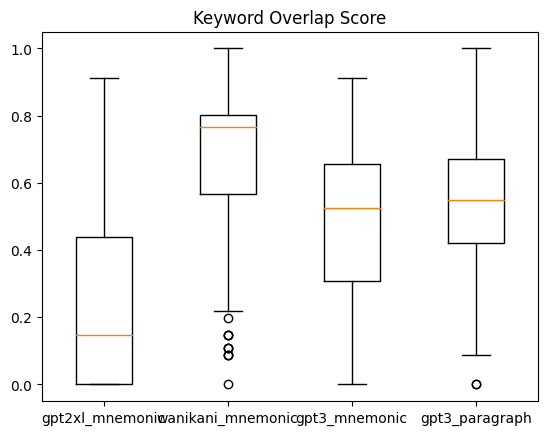

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title('Keyword Overlap Score')
ax.boxplot([ds_overlap[f'{key}_overlap_score'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [20]:
from scipy.stats import f_oneway

f, p = f_oneway(*[ds_overlap[f'{key}_overlap_score'] for key in keys])
print(f, p)

123.6952218271649 3.491991446766124e-65


In [21]:
from scipy.stats import tukey_hsd

data = [ds_overlap[f'{key}_overlap_score'] for key in keys]

res = tukey_hsd(*[ds_overlap[f'{key}_overlap_score'] for key in keys])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.446     0.000    -0.507    -0.385
 (0 - 2)     -0.276     0.000    -0.337    -0.214
 (0 - 3)     -0.308     0.000    -0.369    -0.247
 (1 - 0)      0.446     0.000     0.385     0.507
 (1 - 2)      0.170     0.000     0.109     0.231
 (1 - 3)      0.138     0.000     0.076     0.199
 (2 - 0)      0.276     0.000     0.214     0.337
 (2 - 1)     -0.170     0.000    -0.231    -0.109
 (2 - 3)     -0.033     0.517    -0.094     0.029
 (3 - 0)      0.308     0.000     0.247     0.369
 (3 - 1)     -0.138     0.000    -0.199    -0.076
 (3 - 2)      0.033     0.517    -0.029     0.094



In [22]:
def keyword_concreteness_score(text):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        scores.append(predict_concreteness(keyphrase))

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [23]:
def map_keyword_concreteness_score(example):
    for key in keys:
        example[f'{key}_concreteness_score'] = keyword_concreteness_score(example[key])
    return example

In [24]:
ds_concreteness = ds['train'].map(map_keyword_concreteness_score)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [25]:
f, p = f_oneway(*[ds_concreteness[f'{key}_concreteness_score'] for key in keys])

print(f, p)

1.6040522308858116 0.1870357919562599


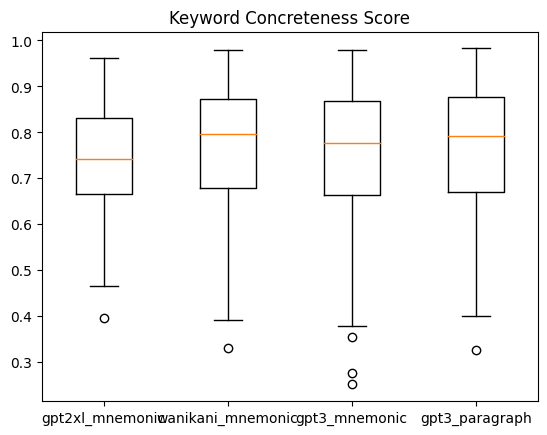

In [26]:
fig, ax = plt.subplots()
ax.set_title('Keyword Concreteness Score')
ax.boxplot([ds_concreteness[f'{key}_concreteness_score'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [27]:
res = tukey_hsd(*[ds_concreteness[f'{key}_concreteness_score'] for key in keys])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.025     0.289    -0.062     0.012
 (0 - 2)     -0.002     0.999    -0.039     0.035
 (0 - 3)     -0.021     0.475    -0.058     0.016
 (1 - 0)      0.025     0.289    -0.012     0.062
 (1 - 2)      0.023     0.368    -0.014     0.060
 (1 - 3)      0.005     0.988    -0.032     0.042
 (2 - 0)      0.002     0.999    -0.035     0.039
 (2 - 1)     -0.023     0.368    -0.060     0.014
 (2 - 3)     -0.019     0.569    -0.056     0.018
 (3 - 0)      0.021     0.475    -0.016     0.058
 (3 - 1)     -0.005     0.988    -0.042     0.032
 (3 - 2)      0.019     0.569    -0.018     0.056



In [28]:
def map_keyword_score(example):
    input_words = example['component_meanings'].split(',') + [example['kanji_meaning']]
    for key in keys:
        example[f'{key}_score'] = keyphrase_score(example[key], input_words)
    return example

In [29]:
ds_combined = ds['train'].map(map_keyword_score)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [30]:
f, p = f_oneway(*[ds_combined[f'{key}_score'] for key in keys])

print(f, p)

1.6040522308858116 0.1870357919562599


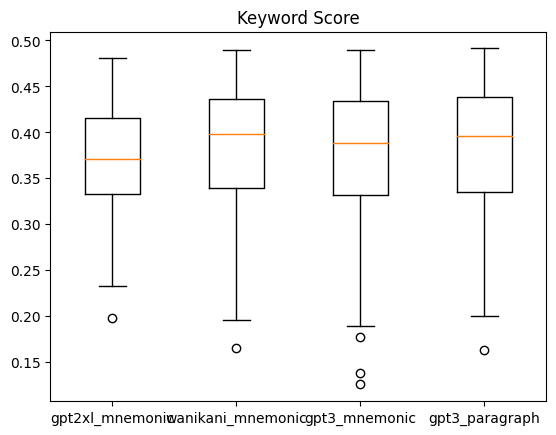

In [31]:
fig, ax = plt.subplots()
ax.set_title('Keyword Score')
ax.boxplot([ds_combined[f'{key}_score'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [32]:
ser_model = DistilBertForSequenceClassification.from_pretrained("martingrzzler/distilbert-sensory-modality").to(device)

In [33]:
def predict_sensory_modality(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=10).to(device)
    inputs.to(device)
    outputs = ser_model(**inputs)
    return outputs.logits.item()

In [34]:
# this model was trained on single words
def keyphrase_sensory_modality_score(text):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        keywords = keyphrase.split(' ')
        word_scores = [predict_sensory_modality(word.lower()) for word in keywords]

        scores.append(np.mean(word_scores))

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [35]:
def map_keyword_sensory_modality_score(example):
    for key in keys:
        example[f'{key}_sensory_modality_score'] = keyphrase_sensory_modality_score(example[key])
    return example

In [36]:
map_keyword_sensory_modality_score(ds['train'][0])

{'kanji_id': 1885,
 'component_meanings': 'woman,catapult',
 'wanikani_mnemonic': "A <radical>woman</radical> loves her <radical>catapult</radical> for some good ol' fashioned <kanji>recreation</kanji>. You ask the woman what she does for fun... for recreation. She says, she goes out and shoots her catapult.",
 'kanji_meaning': 'recreation',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form, recreation of woman being catapulted to her death has been edited out.)\n\n\nAMY GOODMAN: We begin today's show with the shocking news that two women have died after jumping from an overpass near Los Angeles International Airport and landing on I-5 southbound just before",
 'gpt3_paragraph': 'A woman was using a catapult for recreation in her backyard. She was having a blast launching objects into the air and watching them fly. She was enjoying the peacefulness of the moment and the satisfaction of her successful shots.',
 'gpt3_mnemonic': "Once upon a time there was

In [37]:
ds_ser = ds['train'].map(map_keyword_sensory_modality_score)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [38]:
f, p = f_oneway(*[ds_ser[f'{key}_sensory_modality_score'] for key in keys])

print(f, p)

3.2241897567942432 0.022113042246614437


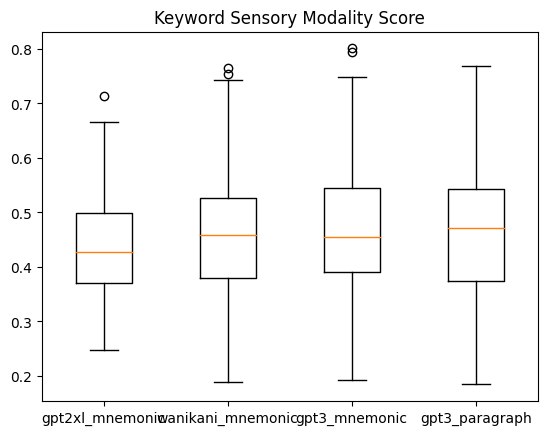

In [39]:
fig, ax = plt.subplots()
ax.set_title('Keyword Sensory Modality Score')
ax.boxplot([ds_ser[f'{key}_sensory_modality_score'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [40]:
img_model = DistilBertForSequenceClassification.from_pretrained("martingrzzler/distilbert-imageability").to(device)

In [41]:
def predict_imageability(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=10).to(device)
    inputs.to(device)
    outputs = img_model(**inputs)
    return outputs.logits.item()

In [42]:
def keyword_imageability_score(text):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        keywords = keyphrase.split(' ')
        word_scores = [predict_imageability(word.lower()) for word in keywords]

        scores.append(np.mean(word_scores))

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [43]:
def map_keyword_imageability_score(example):
    for key in keys:
        example[f'{key}_imageability_score'] = keyword_imageability_score(example[key])
    return example

In [44]:
map_keyword_imageability_score(ds['train'][0])

{'kanji_id': 1885,
 'component_meanings': 'woman,catapult',
 'wanikani_mnemonic': "A <radical>woman</radical> loves her <radical>catapult</radical> for some good ol' fashioned <kanji>recreation</kanji>. You ask the woman what she does for fun... for recreation. She says, she goes out and shoots her catapult.",
 'kanji_meaning': 'recreation',
 'gpt2xl_mnemonic': "This is a rush transcript. Copy may not be in its final form, recreation of woman being catapulted to her death has been edited out.)\n\n\nAMY GOODMAN: We begin today's show with the shocking news that two women have died after jumping from an overpass near Los Angeles International Airport and landing on I-5 southbound just before",
 'gpt3_paragraph': 'A woman was using a catapult for recreation in her backyard. She was having a blast launching objects into the air and watching them fly. She was enjoying the peacefulness of the moment and the satisfaction of her successful shots.',
 'gpt3_mnemonic': "Once upon a time there was

In [45]:
ds_img = ds['train'].map(map_keyword_imageability_score)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [46]:
f, p = f_oneway(*[ds_img[f'{key}_imageability_score'] for key in keys])

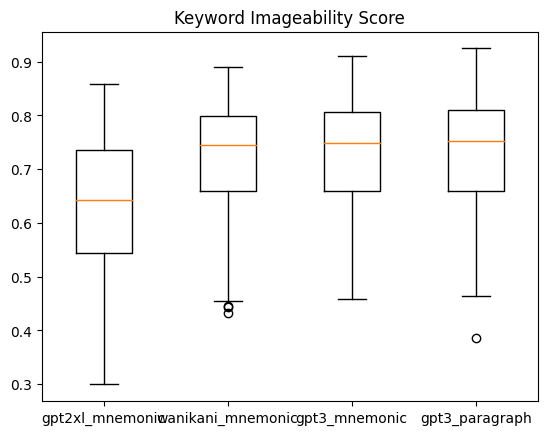

In [47]:
fig, ax = plt.subplots()
ax.set_title('Keyword Imageability Score')
ax.boxplot([ds_img[f'{key}_imageability_score'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [48]:
print(tukey_hsd(*[ds_img[f'{key}_imageability_score'] for key in keys]))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.084     0.000    -0.112    -0.055
 (0 - 2)     -0.092     0.000    -0.121    -0.064
 (0 - 3)     -0.096     0.000    -0.124    -0.067
 (1 - 0)      0.084     0.000     0.055     0.112
 (1 - 2)     -0.009     0.863    -0.037     0.020
 (1 - 3)     -0.012     0.703    -0.040     0.017
 (2 - 0)      0.092     0.000     0.064     0.121
 (2 - 1)      0.009     0.863    -0.020     0.037
 (2 - 3)     -0.003     0.991    -0.032     0.025
 (3 - 0)      0.096     0.000     0.067     0.124
 (3 - 1)      0.012     0.703    -0.017     0.040
 (3 - 2)      0.003     0.991    -0.025     0.032



In [49]:
import numpy as np
def keyphrase_metric(text, input_words):
    keyphrases = get_keyphrases(text)
    scores = []
    for keyphrase in keyphrases:
        scores.append(predict_concreteness(keyphrase) * .5 + \
                       int(input_in_keyphrase(input_words, keyphrase) * .5/3) + \
                       np.mean([predict_sensory_modality(word.lower()) for word in keyphrase.split(' ')]) * .5/3 + \
                          np.mean([predict_imageability(word.lower()) for word in keyphrase.split(' ')]) * .5/3
                      )

    return np.average(scores, weights=1/np.arange(1, len(scores) + 1))

In [50]:
def map_keyword_metric(example):
    input_words = example['component_meanings'].split(',') + [example['kanji_meaning']]
    for key in keys:
        example[f'{key}_metric'] = keyphrase_metric(example[key], input_words)
    return example

In [51]:
ds_metric = ds['train'].map(map_keyword_metric)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [52]:
f, p = f_oneway(*[ds_metric[f'{key}_metric'] for key in keys])

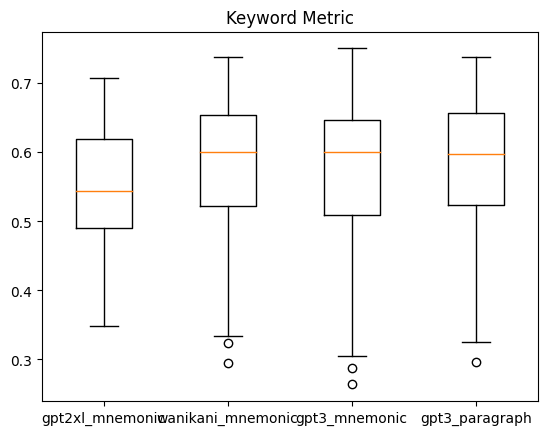

In [53]:
fig, ax = plt.subplots()
ax.set_title('Keyword Metric')
ax.boxplot([ds_metric[f'{key}_metric'] for key in keys])
ax.set_xticklabels(keys)
plt.show()

In [54]:
print(tukey_hsd(*[ds_metric[f'{key}_metric'] for key in keys]))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.031     0.009    -0.056    -0.006
 (0 - 2)     -0.021     0.120    -0.046     0.003
 (0 - 3)     -0.031     0.007    -0.056    -0.006
 (1 - 0)      0.031     0.009     0.006     0.056
 (1 - 2)      0.009     0.776    -0.016     0.034
 (1 - 3)     -0.001     1.000    -0.026     0.024
 (2 - 0)      0.021     0.120    -0.003     0.046
 (2 - 1)     -0.009     0.776    -0.034     0.016
 (2 - 3)     -0.010     0.741    -0.035     0.015
 (3 - 0)      0.031     0.007     0.006     0.056
 (3 - 1)      0.001     1.000    -0.024     0.026
 (3 - 2)      0.010     0.741    -0.015     0.035



In [55]:
ds_metric.to_pandas().sort_values('wanikani_mnemonic_metric', ascending=False)['wanikani_mnemonic'][:3].apply(print)

You see a <radical>tree</radical> growing on a <radical>cliff</radical> and it has <radical>ten thousand</radical> <kanji>horse chestnut</kanji>s growing on it. These trees are rare, only grow on cliffs, and they always have exactly ten thousand horse chestnuts on each one.  Picture this tree, weighed down by it's own horse chestnuts, leaning over the edge of the cliff.
A <radical>lantern</radical> with <radical>horns</radical> that can hold <radical>ten thousand</radical> <radical>drop</radical>s of water is sitting on the <radical>ground</radical>. You get closer and realize it's not a lantern, it's a <kanji>bottle</kanji>. It's got horns, and a weird handle, but it's definitely a bottle with water inside of it. Picture this horned bottle sitting on the ground. You don't know who left it here or why, but it's here and the weirdest looking bottle you've ever seen.
You're standing in the middle of a <radical>rice paddy</radical> in the <radical>rain</radical> with an <radical>umbrella<

60     None
159    None
70     None
Name: wanikani_mnemonic, dtype: object

In [56]:
ds_metric.to_pandas().sort_values('gpt3_paragraph_metric')[:3].apply(lambda x : print(x['kanji_meaning'], x['component_meanings']), axis=1)
ds_metric.to_pandas().sort_values('gpt3_paragraph_metric')['gpt3_paragraph'][:3].apply(print)

recollection soul,idea
evidence say,correct
ethics leader,hat,ground,bookshelf
The soul is a mysterious thing, and it can often hold onto ideas and recollections that one would have thought long forgotten. It is a powerful thing, and it can bring back memories and feelings that have been long buried, and can open up new possibilities and ideas.
It is important to say what is correct and back it up with evidence. Without evidence, it is difficult to prove that what you are saying is true.
The leader wore a hat as he stood on the ground, looking up at the bookshelf filled with books on ethics. He wanted to make sure he was making the right decisions and that his actions were in line with the highest ethical standards.


86     None
182    None
34     None
Name: gpt3_paragraph, dtype: object

In [134]:
keyphrase_metric(ds['train']['gpt3_paragraph'][86], ['recollection', 'soul', 'idea'])

0.27065905375120514

In [138]:
t = 'In a bustling city, a towering skyscraper was intertwined with an ancient tree\'s roots. The roots provided strength and support, but they had a limit. A wise old man warned that if the building grew too tall, the roots would give way and the skyscraper would crumble. This vivid image serves as a reminder: even the mightiest roots have a limit to their support.'
keyphrase_metric(t, ['limit', 'building', 'root'])

0.39502933464887785

These findings are promising but perhaps keywords aren't the best approach or insufficient. 
It may make sense to quantify the connection of the input words somehow. If the words are represented as a graph,
it may be very useful to extract the edges between the input words.

In [139]:
get_keyphrases(t)

['ancient trees roots',
 'support',
 'limit',
 'towering skyscraper',
 'strength',
 'way',
 'wise old man',
 'vivid image',
 'reminder',
 'building',
 'bustling city']